# ML Task 2.2 - Complex ML models and keras - Part 2 - BONUS TASK 1

## Table of Contents

#### 01. Import libraries and datasets

#### 02. Data preprocessing

#### 03. Bonus Task 1: Weather dataset preprocessing changes, z-score scaling, CNN model build & run, confusion matrices, learning curves

#### 04. LSTM vs CNN model results comparison for Bonus Tasks 1 & 2

### 01. Import libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from numpy import unique
from numpy import reshape
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, Dense, BatchNormalization, Flatten, MaxPooling1D, Dropout, LSTM, Input # changed line
from sklearn.model_selection import train_test_split
from keras import utils # changed line
from keras.utils import to_categorical  # changed line

In [3]:
# Create path to dataset location
path = r'C:\Users\dirk8\CareerFoundry\07-2025 Machine Learning With Python\Datasets\Unsupervised'

In [5]:
# Import unscaled weather dataset and Pleasant Weather answers dataset, respectively, without the index column
df_unscaled = pd.read_excel(os.path.join(path, 'cleaned_weather_data_task_2.2.xlsx'), index_col=None)
pleas_ans = pd.read_excel(os.path.join(path, 'answers_pleasant_weather_no_date.xlsx'), index_col=None)

### 02. Data preprocessing

#### Comment: The unscaled weather dataset uploaded here was already preprocessed in the Excel file as follows: (i) 'DATE' and 'MONTH' columns were dropped as we only need numerical data for the RNN (LSTM) and CNN model inputs; (ii) Roma, Gdansk & Tours weather stations and all their associated weather features (columns) were dropped; (iii) the 'snow_depth' (only 6 weather stations had this feature) and 'wind_speed' (only 9 weather stations had this feature) weather features (columns) were dropped from ALL weather stations, to ensure that we have an identical (and in the exact same sequence) set of nine (9) weather features per weather station; (iv) 'cloud_cover' weather feature was only missing for Kassel weather station, so Dusseldorf (229 km away, similar latitude) weather station's data series for that feature was copied to Kassel; (v) 'pressure' weather feature was only missing for MunchenB weather station, so Basel (which has a closer latitude to Munich than Sonnblick does, and a 260-metre elevation versus Sonnblick's 3,100 metres) weather station's data series for that feature was copied to MunchenB; and (vi) 'humidity' weather feature was only missing for Stockholm weather station, so Oslo (similar latitude, also a coastal city) weather station's data series for that feature was copied to Stockholm.

#### Meanwhile, in the Pleasant weather answers dataset uploaded here, the 'DATE' column was dropped as it is not needed for the RNN and CNN model runs in this exercise.

In [7]:
# Check dimensions
print(df_unscaled.shape)
print(pleas_ans.shape)

(22950, 135)
(22950, 15)


In [9]:
# Check a few lines of the weather dataset
df_unscaled.head(2)

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,...,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
0,7,0.85,1.018,0.32,0.09,0.7,6.5,0.8,10.9,1,...,4.9,5,0.88,1.0003,0.45,0.34,4.7,8.5,6.0,10.9
1,6,0.84,1.018,0.36,1.05,1.1,6.1,3.3,10.1,6,...,5.0,7,0.91,1.0007,0.25,0.84,0.7,8.9,5.6,12.1


In [11]:
# Check a few lines of the Pleasant weather answers dataset
pleas_ans.head(2)

,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# Check for missing data in the weather dataset
df_unscaled.isnull().sum().sum()

0

In [15]:
# Check for missing data in the Pleasant weather answers dataset
pleas_ans.isnull().sum().sum()

0

#### Comment: No export of the datasets is needed as these were already preprocessed in Excel form, as confirmed above.

### 03. Bonus Task 1: Weather dataset preprocessing changes, z-score scaling, CNN model build & run, confusion matrices, learning curves

In [19]:
print(df_unscaled.shape)
print(pleas_ans.shape)

(22950, 135)
(22950, 15)


In [21]:
df_unscaled.head(2)

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,...,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
0,7,0.85,1.018,0.32,0.09,0.7,6.5,0.8,10.9,1,...,4.9,5,0.88,1.0003,0.45,0.34,4.7,8.5,6.0,10.9
1,6,0.84,1.018,0.36,1.05,1.1,6.1,3.3,10.1,6,...,5.0,7,0.91,1.0007,0.25,0.84,0.7,8.9,5.6,12.1


In [23]:
pleas_ans.head(2)

,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### To correct some of the key problems that arose from the Task 2.2 instructions, we need to (i) structure the datasets and run the DL models on a per-station basis (not on the group), to enable like-with-like matching with the binary answers dataset, which has one data value (binary outcome) per day per station; and (ii) z-score rescale (standardize) the weather data, whose measurements otherwise have differing scales when left in their original form (posing non-uniform scale problems for DL models).

Why not use MinMax normalization similar to the +1 to -1 scale in the HAR (Human Activity Recognition) case study? MinMax normalization is sensitive to outliers (a single extreme outlier can "squash" the rest of the data into a very small range, shrouding useful patterns within), while z-score standardization is more robust to these. MinMax also relies on minimum and maximum values, and if new data points fall outside the original range, the scaling will be incorrect. This is a material "bounded data" weak point for any model seeking to make predictions on unseen, future weather data (which can easily move beyond maxima and/or minima).

#### The defined function wrapped in the script below prepares the per-station weather data for both the CNN and LSTM variant (of RNN) models using 30-day sliding windows.  30 days was selected as the "timestep" to capture shorter-cycle weather patterns in a rolling-window.  Temperature-related features were confirmed in an earlier Exercise's ACF plots to be highly autocorrelated over time.  Recent weather, for at least some weather features, tends to impact heavily what comes next.  The script below covers:

1. Splitting the df_unscaled and pleas_ans datasets into 15 per-station datasets
2. Train/test splitting (75/25)
3. StandardScaler fit (on train only)
4. Scaling train and test sets
5. Reshaping data for deep learning with a window size of 30 timesteps
6. Storing reshaped datasets in a structured dictionary per station

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Config
stations = [
    'BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 'HEATHROW', 'KASSEL',
    'LJUBLJANA', 'MAASTRICHT', 'MADRID', 'MUNCHENB', 'OSLO', 'SONNBLICK', 'STOCKHOLM', 'VALENTIA'
]
features_per_station = 9
timesteps = 30
test_size = 0.25
random_state = 42

# Output dictionary
data_per_station = {}

# 1–6: Preprocessing Loop
for station in stations:
    # 1. Slice weather + label for the station
    X_full = df_unscaled.loc[:, df_unscaled.columns.str.startswith(f"{station}_")].copy().values
    y_full = pleas_ans[f"{station}_pleasant_weather"].values

    # 2. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y_full, test_size=test_size, random_state=random_state, shuffle=False
    )

    # 3. Fit scaler only on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4. Create windowed sequences for LSTM/CNN
    def create_sequences(X, y, window):
        Xs, ys = [], []
        for i in range(window, len(X)):
            Xs.append(X[i-window:i])
            ys.append(y[i])
        return np.array(Xs), np.array(ys)

    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, timesteps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, timesteps)

    # 5. Save to dictionary
    data_per_station[station] = {
        'X_train': X_train_seq,
        'X_test': X_test_seq,
        'y_train': y_train_seq,
        'y_test': y_test_seq,
        'scaler': scaler
    }

print(f"✅ Preprocessed data for {len(data_per_station)} stations.")
print(f"Example shape (X_train) for BASEL:", data_per_station['BASEL']['X_train'].shape)

✅ Preprocessed data for 15 stations.
Example shape (X_train) for BASEL: (17182, 30, 9)


#### Next, the script below builds, trains and evaluates a CNN model for each of the 15 weather stations. This is done in a batch-processing loop, generating per-station results with:

* Balanced accuracy
* Weighted F1 score
* Precision
* Recall
* Confusion matrix

Note: "Balanced Accuracy" is preferred over "Overall Accuracy" when the answers dataset has a class imbalance (e.g., approximately 75% of the days over 60+ years were recorded as "Unpleasant" weather, with only 25% as "Pleasant"), which makes predicting the minority class outcome more challenging.


🌀 CNN Processing station: BASEL
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7630 - loss: 0.4501 - precision: 0.5047 - recall: 0.4273 - val_accuracy: 0.7489 - val_loss: 0.4464 - val_precision: 0.5385 - val_recall: 0.5651
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7708 - loss: 0.4076 - precision: 0.5237 - recall: 0.4497 - val_accuracy: 0.7433 - val_loss: 0.4367 - val_precision: 0.5270 - val_recall: 0.5888
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7733 - loss: 0.4032 - precision: 0.5293 - recall: 0.4621 - val_accuracy: 0.7383 - val_loss: 0.4443 - val_precision: 0.5352 - val_recall: 0.3169
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7753 - loss: 0.4014 - precision: 0.5369 - recall: 0.4324 - val_accuracy: 0.7328 - val_loss: 0.4521 - val_precision: 0.5121 - val_recall: 0.4618
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7756 - loss: 0.3985 - precision: 0.5401 - recall: 0

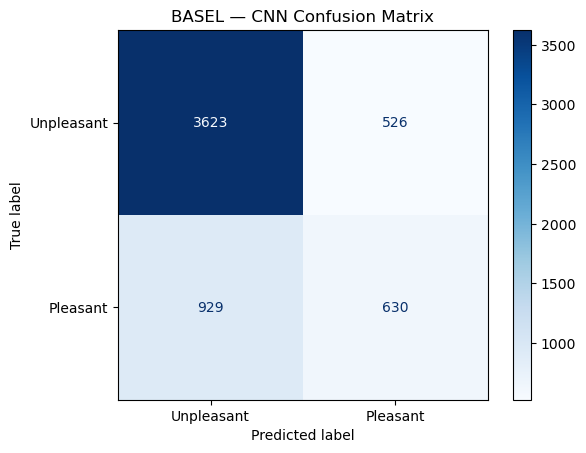


🌀 CNN Processing station: BELGRADE
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7293 - loss: 0.5306 - precision: 0.5996 - recall: 0.6043 - val_accuracy: 0.7451 - val_loss: 0.4923 - val_precision: 0.6569 - val_recall: 0.6893
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7535 - loss: 0.4797 - precision: 0.6258 - recall: 0.6773 - val_accuracy: 0.7458 - val_loss: 0.4933 - val_precision: 0.6613 - val_recall: 0.6787
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7540 - loss: 0.4739 - precision: 0.6235 - recall: 0.6907 - val_accuracy: 0.7505 - val_loss: 0.4914 - val_precision: 0.6646 - val_recall: 0.6934
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7551 - loss: 0.4704 - precision: 0.6219 - recall: 0.7064 - val_accuracy: 0.7514 - val_loss: 0.4888 - val_precision: 0.6603 - val_recall: 0.7123
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7583 - loss: 0.4687 - precision: 0.6257 - recall

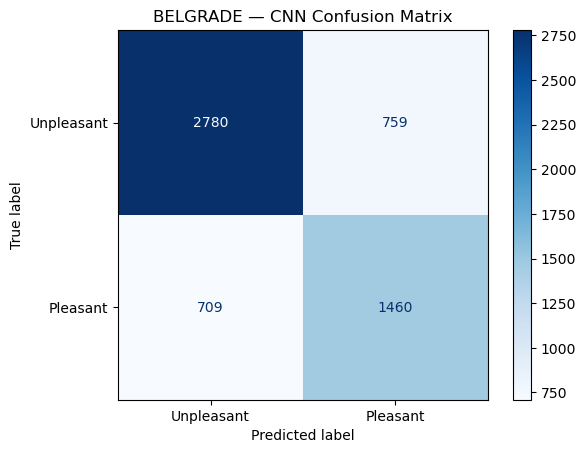


🌀 CNN Processing station: BUDAPEST
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7769 - loss: 0.4554 - precision: 0.6408 - recall: 0.7043 - val_accuracy: 0.7956 - val_loss: 0.4997 - val_precision: 0.6745 - val_recall: 0.7310
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7903 - loss: 0.4176 - precision: 0.6491 - recall: 0.7640 - val_accuracy: 0.7963 - val_loss: 0.5011 - val_precision: 0.6635 - val_recall: 0.7720
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7895 - loss: 0.4121 - precision: 0.6439 - recall: 0.7803 - val_accuracy: 0.7985 - val_loss: 0.5009 - val_precision: 0.6668 - val_recall: 0.7741
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7919 - loss: 0.4106 - precision: 0.6450 - recall: 0.7914 - val_accuracy: 0.7959 - val_loss: 0.5168 - val_precision: 0.6690 - val_recall: 0.7507
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7901 - loss: 0.4081 - precision: 0.6403 - recall

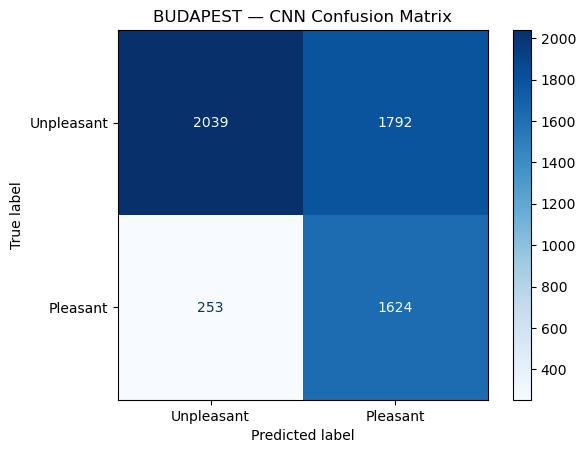


🌀 CNN Processing station: DEBILT
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8039 - loss: 0.3853 - precision: 0.4580 - recall: 0.3172 - val_accuracy: 0.7787 - val_loss: 0.3886 - val_precision: 0.5078 - val_recall: 0.3082
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8162 - loss: 0.3464 - precision: 0.5077 - recall: 0.2704 - val_accuracy: 0.7780 - val_loss: 0.3859 - val_precision: 0.5247 - val_recall: 0.0667
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8195 - loss: 0.3403 - precision: 0.5275 - recall: 0.2503 - val_accuracy: 0.7875 - val_loss: 0.3851 - val_precision: 0.5945 - val_recall: 0.1529
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8210 - loss: 0.3377 - precision: 0.5344 - recall: 0.2632 - val_accuracy: 0.7842 - val_loss: 0.3819 - val_precision: 0.5247 - val_recall: 0.3576
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8205 - loss: 0.3363 - precision: 0.5391 - recall: 

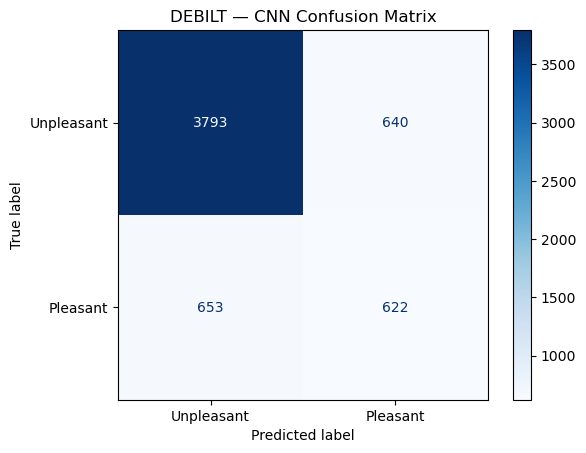


🌀 CNN Processing station: DUSSELDORF
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7805 - loss: 0.4213 - precision: 0.4620 - recall: 0.3461 - val_accuracy: 0.7609 - val_loss: 0.4233 - val_precision: 0.5010 - val_recall: 0.1779
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7950 - loss: 0.3804 - precision: 0.5104 - recall: 0.3159 - val_accuracy: 0.7584 - val_loss: 0.4251 - val_precision: 0.4944 - val_recall: 0.4180
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7983 - loss: 0.3707 - precision: 0.5228 - recall: 0.3279 - val_accuracy: 0.7663 - val_loss: 0.4226 - val_precision: 0.5261 - val_recall: 0.2365
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7985 - loss: 0.3680 - precision: 0.5254 - recall: 0.3038 - val_accuracy: 0.7623 - val_loss: 0.4309 - val_precision: 0.5070 - val_recall: 0.2372
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8010 - loss: 0.3674 - precision: 0.5387 - reca

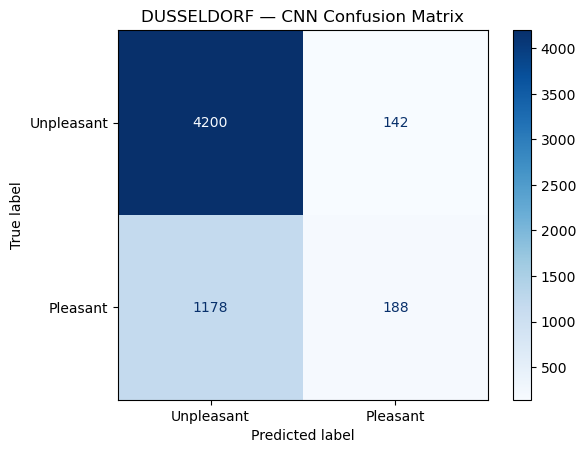


🌀 CNN Processing station: HEATHROW
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7925 - loss: 0.4027 - precision: 0.5023 - recall: 0.4599 - val_accuracy: 0.7775 - val_loss: 0.4023 - val_precision: 0.5543 - val_recall: 0.3999
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8093 - loss: 0.3485 - precision: 0.5459 - recall: 0.5066 - val_accuracy: 0.7703 - val_loss: 0.4084 - val_precision: 0.5384 - val_recall: 0.3411
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8098 - loss: 0.3454 - precision: 0.5503 - recall: 0.4781 - val_accuracy: 0.7717 - val_loss: 0.3997 - val_precision: 0.5430 - val_recall: 0.3440
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8133 - loss: 0.3415 - precision: 0.5607 - recall: 0.4812 - val_accuracy: 0.7794 - val_loss: 0.4094 - val_precision: 0.5594 - val_recall: 0.4064
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8124 - loss: 0.3399 - precision: 0.5607 - recall

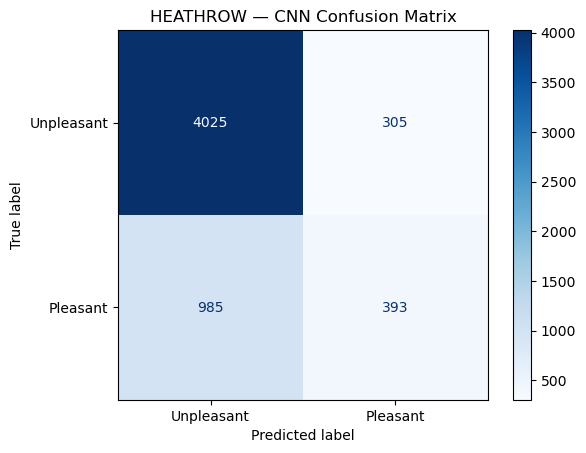


🌀 CNN Processing station: KASSEL
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7943 - loss: 0.4133 - precision: 0.4443 - recall: 0.3365 - val_accuracy: 0.8984 - val_loss: 0.3168 - val_precision: 0.4093 - val_recall: 0.2899
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8074 - loss: 0.3629 - precision: 0.4848 - recall: 0.2454 - val_accuracy: 0.9061 - val_loss: 0.3271 - val_precision: 0.4421 - val_recall: 0.1634
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8088 - loss: 0.3552 - precision: 0.4908 - recall: 0.2046 - val_accuracy: 0.9110 - val_loss: 0.3294 - val_precision: 0.6071 - val_recall: 0.0331
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8128 - loss: 0.3515 - precision: 0.5195 - recall: 0.1758 - val_accuracy: 0.9080 - val_loss: 0.3454 - val_precision: 0.4812 - val_recall: 0.2743
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8133 - loss: 0.3498 - precision: 0.5197 - recall: 

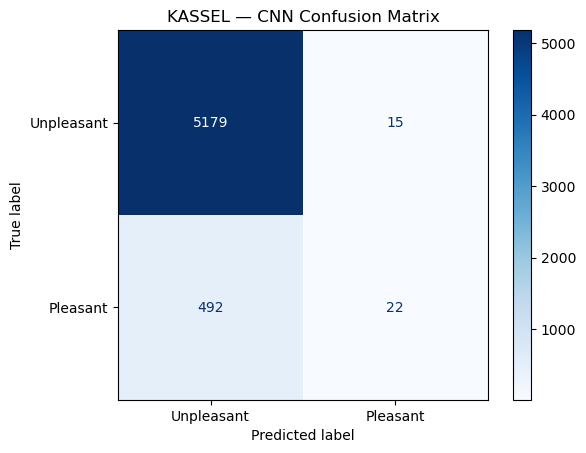


🌀 CNN Processing station: LJUBLJANA
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7408 - loss: 0.4910 - precision: 0.5171 - recall: 0.5391 - val_accuracy: 0.7556 - val_loss: 0.4536 - val_precision: 0.5875 - val_recall: 0.6870
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7626 - loss: 0.4267 - precision: 0.5546 - recall: 0.5941 - val_accuracy: 0.7533 - val_loss: 0.4515 - val_precision: 0.5800 - val_recall: 0.7149
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7623 - loss: 0.4208 - precision: 0.5540 - recall: 0.5941 - val_accuracy: 0.7558 - val_loss: 0.4464 - val_precision: 0.5840 - val_recall: 0.7132
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7635 - loss: 0.4175 - precision: 0.5567 - recall: 0.5910 - val_accuracy: 0.7481 - val_loss: 0.4478 - val_precision: 0.5896 - val_recall: 0.5929
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7628 - loss: 0.4153 - precision: 0.5587 - recal

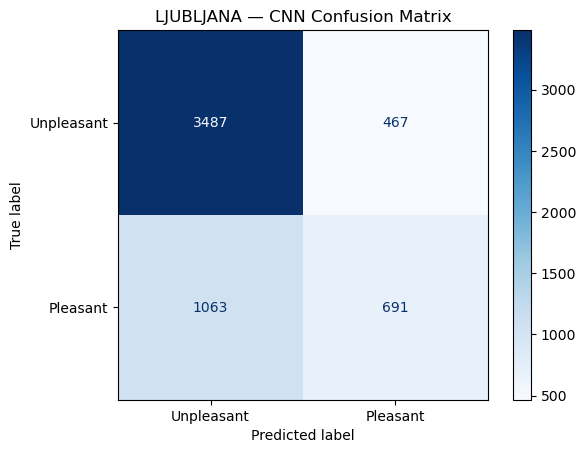


🌀 CNN Processing station: MAASTRICHT
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7921 - loss: 0.4124 - precision: 0.4636 - recall: 0.3456 - val_accuracy: 0.7698 - val_loss: 0.4210 - val_precision: 0.5429 - val_recall: 0.2939
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8041 - loss: 0.3696 - precision: 0.5057 - recall: 0.2890 - val_accuracy: 0.7763 - val_loss: 0.4139 - val_precision: 0.5374 - val_recall: 0.5269
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8060 - loss: 0.3615 - precision: 0.5143 - recall: 0.2866 - val_accuracy: 0.7805 - val_loss: 0.4116 - val_precision: 0.6134 - val_recall: 0.2453
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8078 - loss: 0.3568 - precision: 0.5243 - recall: 0.2739 - val_accuracy: 0.7740 - val_loss: 0.4125 - val_precision: 0.5412 - val_recall: 0.4194
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8096 - loss: 0.3564 - precision: 0.5337 - reca

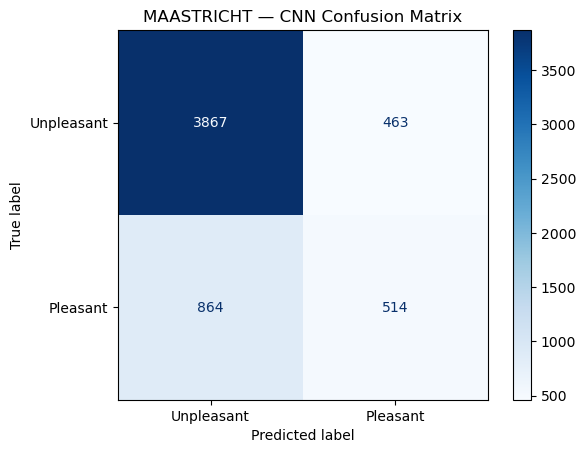


🌀 CNN Processing station: MADRID
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8026 - loss: 0.4395 - precision: 0.7710 - recall: 0.7777 - val_accuracy: 0.8134 - val_loss: 0.4053 - val_precision: 0.8192 - val_recall: 0.7887
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8191 - loss: 0.4099 - precision: 0.7830 - recall: 0.8086 - val_accuracy: 0.8166 - val_loss: 0.3985 - val_precision: 0.8128 - val_recall: 0.8072
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8176 - loss: 0.4056 - precision: 0.7787 - recall: 0.8116 - val_accuracy: 0.8181 - val_loss: 0.3984 - val_precision: 0.8136 - val_recall: 0.8101
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8201 - loss: 0.4017 - precision: 0.7804 - recall: 0.8166 - val_accuracy: 0.8217 - val_loss: 0.3954 - val_precision: 0.8138 - val_recall: 0.8191
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8221 - loss: 0.4013 - precision: 0.7800 - recall: 

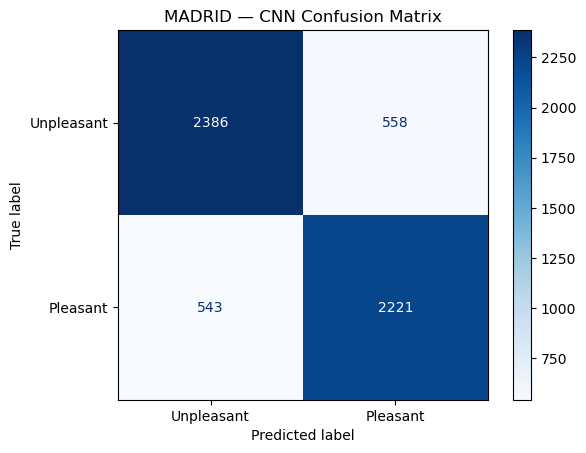


🌀 CNN Processing station: MUNCHENB
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7682 - loss: 0.4594 - precision: 0.3878 - recall: 0.3031 - val_accuracy: 0.7547 - val_loss: 0.4463 - val_precision: 0.4671 - val_recall: 0.1080
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7971 - loss: 0.3910 - precision: 0.4620 - recall: 0.1774 - val_accuracy: 0.7549 - val_loss: 0.4369 - val_precision: 0.4819 - val_recall: 0.1929
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7980 - loss: 0.3850 - precision: 0.4305 - recall: 0.0759 - val_accuracy: 0.7575 - val_loss: 0.4397 - val_precision: 0.1429 - val_recall: 7.2516e-04
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8021 - loss: 0.3806 - precision: 0.4904 - recall: 0.0909 - val_accuracy: 0.7572 - val_loss: 0.4362 - val_precision: 0.3871 - val_recall: 0.0087
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8015 - loss: 0.3786 - precision: 0.4572 - re

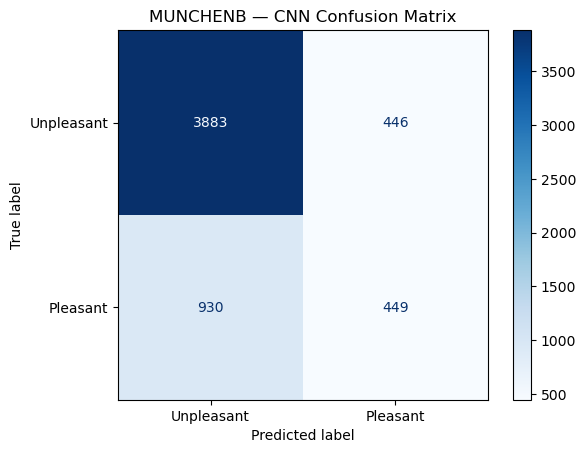


🌀 CNN Processing station: OSLO
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8368 - loss: 0.3165 - precision: 0.4648 - recall: 0.3500 - val_accuracy: 0.8316 - val_loss: 0.3049 - val_precision: 0.4487 - val_recall: 0.2151
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8475 - loss: 0.2781 - precision: 0.5129 - recall: 0.3147 - val_accuracy: 0.8400 - val_loss: 0.3020 - val_precision: 0.5128 - val_recall: 0.0655
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8484 - loss: 0.2729 - precision: 0.5228 - recall: 0.2542 - val_accuracy: 0.8413 - val_loss: 0.2991 - val_precision: 0.5472 - val_recall: 0.0633
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8469 - loss: 0.2705 - precision: 0.5124 - recall: 0.2482 - val_accuracy: 0.8332 - val_loss: 0.2979 - val_precision: 0.4581 - val_recall: 0.2151
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8507 - loss: 0.2677 - precision: 0.5367 - recall: 0.

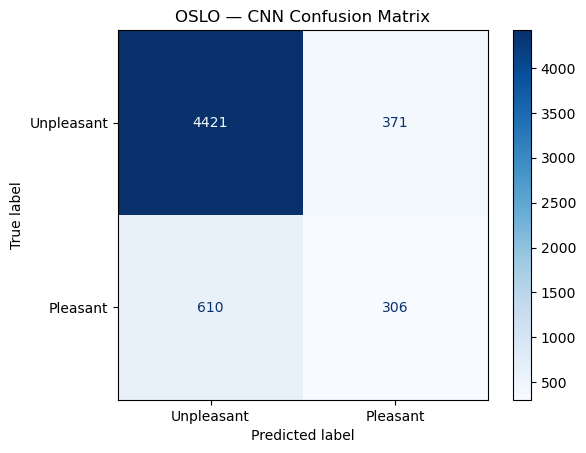


🌀 CNN Processing station: SONNBLICK
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9926 - loss: 0.0234 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 2.2084e-04 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 5.1679e-04 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 6.9910e-05 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 2.0869e-04 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 3.2566e-05 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 8.9469e-05 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 1.4459e-05 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
1074/1074 ━━

C:\Users\dirk8\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


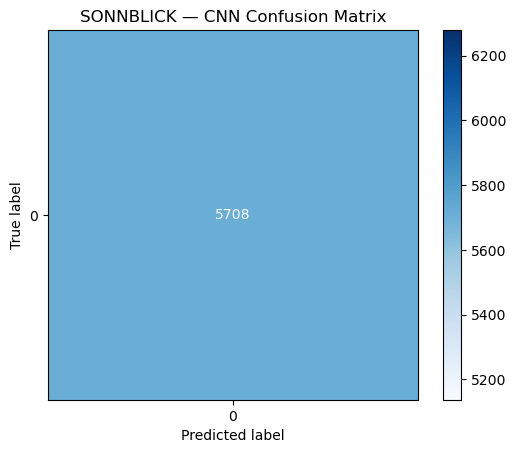


🌀 CNN Processing station: STOCKHOLM
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8182 - loss: 0.3722 - precision: 0.4343 - recall: 0.4398 - val_accuracy: 0.8238 - val_loss: 0.3111 - val_precision: 0.5708 - val_recall: 0.4675
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8439 - loss: 0.2932 - precision: 0.5172 - recall: 0.4028 - val_accuracy: 0.8218 - val_loss: 0.3116 - val_precision: 0.5750 - val_recall: 0.4077
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8447 - loss: 0.2816 - precision: 0.5206 - recall: 0.3995 - val_accuracy: 0.8106 - val_loss: 0.3169 - val_precision: 0.5481 - val_recall: 0.2856
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8476 - loss: 0.2760 - precision: 0.5319 - recall: 0.4144 - val_accuracy: 0.8281 - val_loss: 0.3209 - val_precision: 0.5674 - val_recall: 0.5808
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8469 - loss: 0.2732 - precision: 0.5293 - recal

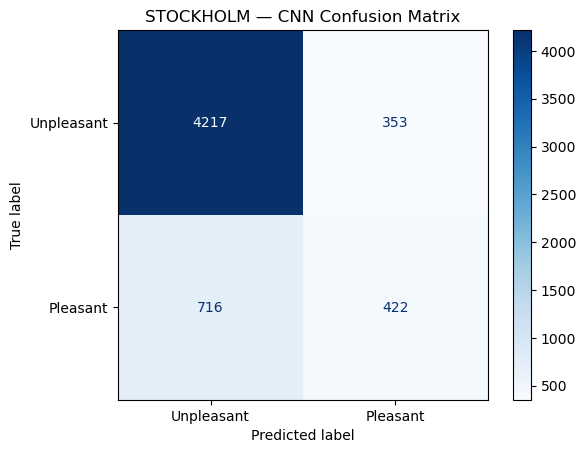


🌀 CNN Processing station: VALENTIA
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9267 - loss: 0.2263 - precision: 0.1743 - recall: 0.0340 - val_accuracy: 0.9900 - val_loss: 0.3162 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9346 - loss: 0.1972 - precision: 0.2667 - recall: 0.0036 - val_accuracy: 0.9900 - val_loss: 0.2445 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9353 - loss: 0.1911 - precision: 0.7778 - recall: 0.0063 - val_accuracy: 0.9900 - val_loss: 0.2307 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9350 - loss: 0.1895 - precision: 0.5556 - recall: 0.0045 - val_accuracy: 0.9900 - val_loss: 0.2069 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9349 - loss: 0.1

C:\Users\dirk8\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dirk8\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dirk8\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dirk8\anaconda3\Lib\site-packages\sklea

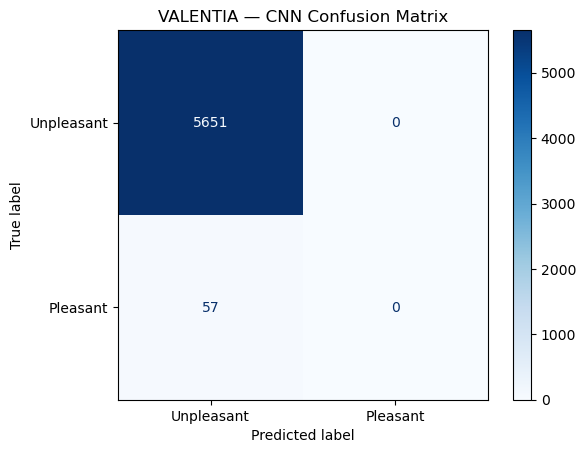

,Balanced_Accuracy,F1_Score_Weighted,Recall,Precision
Station,,,,
BASEL,0.6387,0.7321,0.4041,0.5450
BELGRADE,0.7293,0.7434,0.6731,0.6580
BUDAPEST,0.6987,0.6488,0.8652,0.4754
DEBILT,0.6717,0.7731,0.4878,0.4929
DUSSELDORF,0.5525,0.7104,0.1376,0.5697
HEATHROW,0.6074,0.7452,0.2852,0.5630
KASSEL,0.5200,0.8747,0.0428,0.5946
LJUBLJANA,0.6379,0.7139,0.3940,0.5967
MAASTRICHT,0.6330,0.7529,0.3730,0.5261


In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    balanced_accuracy_score, precision_score, recall_score, f1_score
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dropout, Dense

# Setup
stations = ['BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 'HEATHROW',
            'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 'MUNCHENB',
            'OSLO', 'SONNBLICK', 'STOCKHOLM', 'VALENTIA']

weather_features = ['cloud_cover', 'humidity', 'pressure', 'global_radiation',
                    'precipitation', 'sunshine', 'temp_mean', 'temp_min', 'temp_max']

# Hyperparameters
timesteps = 30
batch_size = 16
epochs = 30
metrics_table = []
histories = []

# Function to convert time-series into supervised sequence format
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i - window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# Main loop
for station in stations:
    print(f"\n🌀 CNN Processing station: {station}")

    # 1. Select station features and labels
    station_cols = [f"{station}_{f}" for f in weather_features]
    X_df = df_unscaled[station_cols].copy()
    y_df = pleas_ans[[f"{station}_pleasant_weather"]].copy()

    # 2. Split without shuffling (preserve temporal order)
    X_train, X_test, y_train, y_test = train_test_split(
        X_df, y_df, test_size=0.25, random_state=42, shuffle=False
    )

    # 3. Scale features based on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4. Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, timesteps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, timesteps)

    # 5. CNN model definition
    model = Sequential()
    model.add(Input(shape=(timesteps, len(weather_features))))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    # 6. Model training
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_test_seq, y_test_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    histories.append(history)

    # 7. Predictions
    y_pred_prob = model.predict(X_test_seq).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # Handle class imbalance for SONNBLICK if necessary
    if len(np.unique(y_test_seq)) == 1:
        labels = [str(np.unique(y_test_seq)[0])]
        print(f"⚠️ Only one class present in y_test for {station}, skipping full report...")
        report = "Skipped due to imbalance"
        cm = confusion_matrix(y_test_seq, y_pred, labels=[0])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    else:
        # Evaluation
        bal_acc = balanced_accuracy_score(y_test_seq, y_pred)
        f1 = f1_score(y_test_seq, y_pred, average='weighted')
        recall = recall_score(y_test_seq, y_pred)
        precision = precision_score(y_test_seq, y_pred)

        print(f"\n📊 CNN Results for {station}")
        print(f"Balanced Accuracy: {bal_acc:.4f}")
        print(f"F1 Score (Weighted): {f1:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Precision: {precision:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test_seq, y_pred, target_names=['Unpleasant (0)', 'Pleasant (1)']))

        metrics_table.append({
            "Station": station,
            "Balanced_Accuracy": round(bal_acc, 4),
            "F1_Score_Weighted": round(f1, 4),
            "Recall": round(recall, 4),
            "Precision": round(precision, 4)
        })

        # Plot confusion matrix
        cm = confusion_matrix(y_test_seq, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Unpleasant', 'Pleasant'])

    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{station} — CNN Confusion Matrix")
    plt.grid(False)
    plt.show()

# Save histories for plotting
cnn_histories = histories

# Final summary table
results_df = pd.DataFrame(metrics_table)
results_df.set_index("Station", inplace=True)
results_df

#### The script below generates a grid of train & test learning curves to evaluate degree of model overfit at each weather station

C:\Users\dirk8\AppData\Local\Temp\ipykernel_21588\316638154.py:32: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
C:\Users\dirk8\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


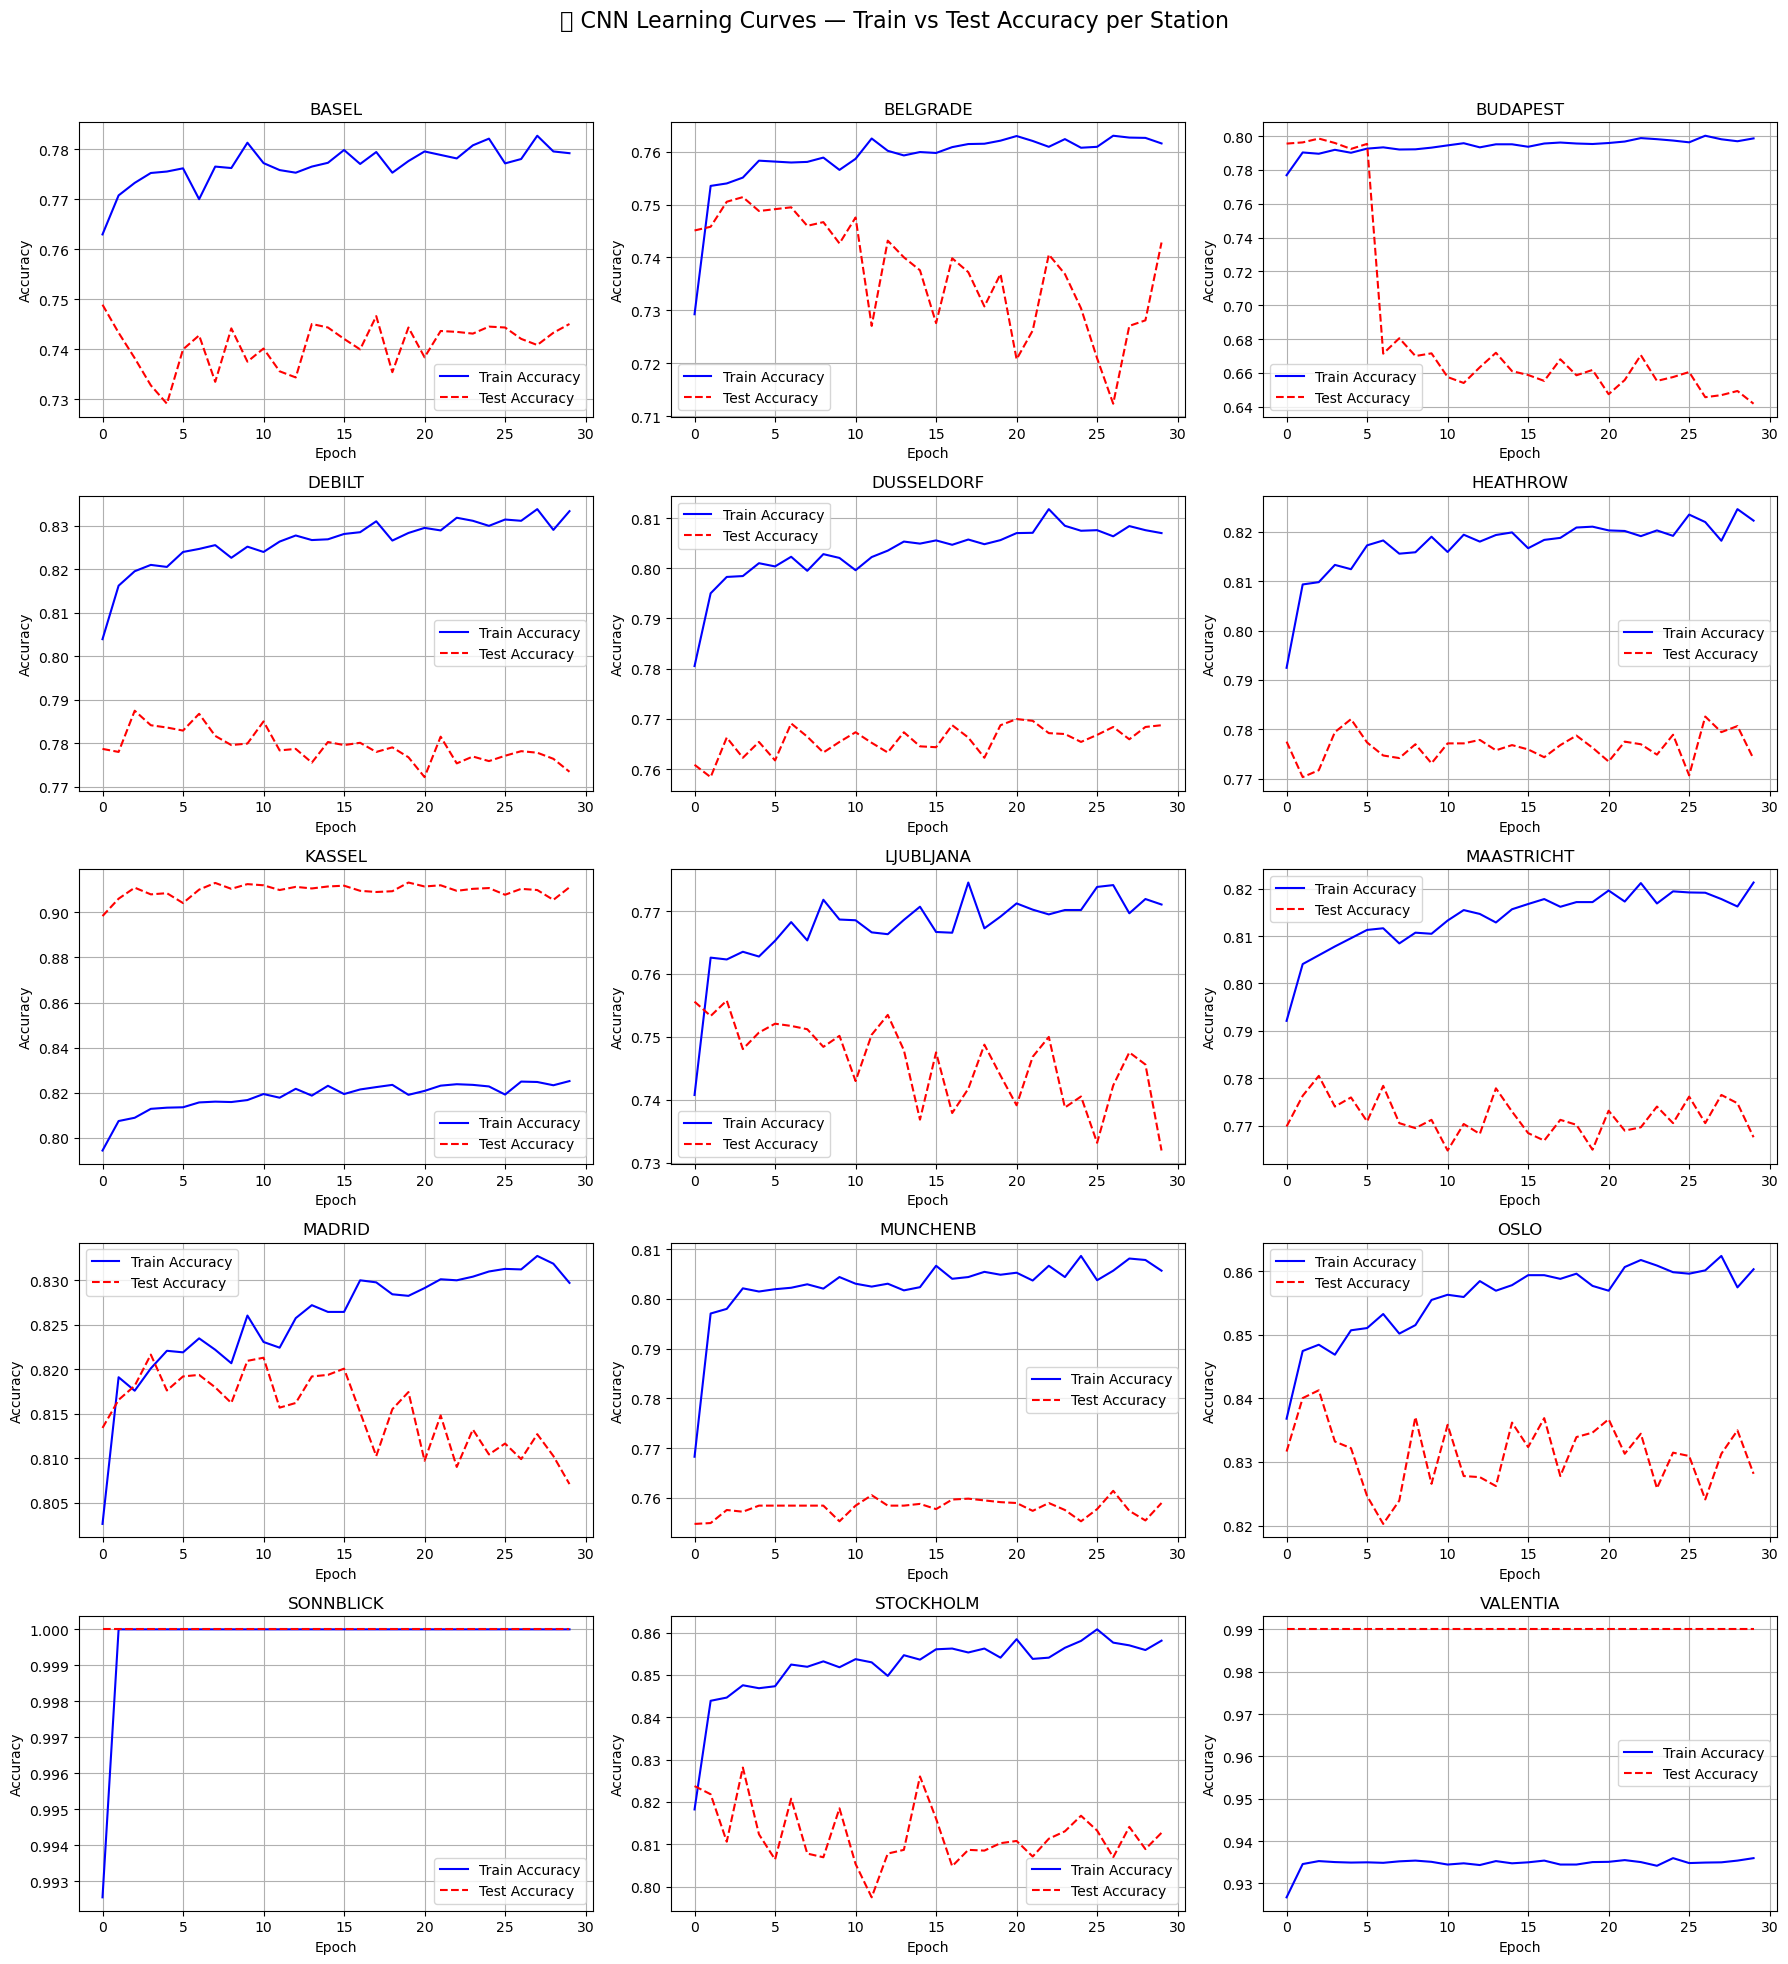

In [39]:
import matplotlib.pyplot as plt
import math

# Optional: Adjust font or suppress warning about missing glyphs
plt.rcParams['axes.unicode_minus'] = False

# Number of subplots
num_stations = len(stations)
cols = 3
rows = math.ceil(num_stations / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
fig.suptitle("🧠 CNN Learning Curves — Train vs Test Accuracy per Station", fontsize=16)

for idx, station in enumerate(stations):
    row, col = divmod(idx, cols)
    ax = axes[row, col]

    history = cnn_histories[idx]  # Each history is a Keras History object
    ax.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    ax.plot(history.history['val_accuracy'], label='Test Accuracy', linestyle='--', color='red')
    ax.set_title(station, fontsize=12)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)

# Hide any unused subplots (if total < rows * cols)
for i in range(num_stations, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()


### 04. LSTM vs CNN model results comparison for Bonus Tasks 1 & 2

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [12]:
# Create path to dataset location
path = r'C:\Users\dirk8\CareerFoundry\07-2025 Machine Learning With Python\Datasets\Unsupervised'

In [14]:
# Import LSTM vs CNN summary table without the index column
lstm_cnn_comparison_table = pd.read_excel(os.path.join(path, 'Summary LSTM & CNN Per-Station Results Comparison.xlsx'), index_col=None)

In [16]:
lstm_cnn_comparison_table

,Weather Station,Model,Balanced Accuracy,F1 Score (Weighted),Recall (Pleasant),Precision (Pleasant)
0,Basel,LSTM,0.771100,0.825800,0.645300,0.701500
1,Basel,CNN,0.638700,0.732100,0.404100,0.545000
2,Belgrade,LSTM,0.810700,0.815400,0.796200,0.736100
3,Belgrade,CNN,0.729300,0.743400,0.673100,0.658000
4,Budapest,LSTM,0.838900,0.836900,0.855100,0.702700
5,Budapest,CNN,0.698700,0.648800,0.865200,0.475400
6,Debilt,LSTM,0.738300,0.843200,0.532500,0.732500
7,Debilt,CNN,0.671700,0.773100,0.487800,0.492900
8,Dusseldorf,LSTM,0.756900,0.831000,0.609800,0.666400
9,Dusseldorf,CNN,0.552500,0.710400,0.137600,0.569700
